# Домашка №4

In [2]:
import warnings
from typing import Tuple

import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch import nn

warnings.filterwarnings("ignore")

### Задание 1

### Читаем текст

In [2]:
with open(r"120_tysyach_anekdotov\anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
    
text = text.replace("\n\n", "").split("<|startoftext|>")[1:]

### Делаем корпус из всех анекдотов и переводим в нижний регистр

In [3]:
all_texts = ''.join(text).lower()

### Посмотрим какие у нас есть символы

In [4]:
value_counts = {}
for char in all_texts:
    if char not in value_counts:
        value_counts[char] = 1
    else:
        value_counts[char] += 1
char_count = sum(value_counts.values())
for key in value_counts.keys():
    value_counts[key] = value_counts[key] / char_count

In [5]:
value_counts

{'т': 0.0550261857987924,
 'о': 0.08254287589812817,
 'л': 0.03136620272961345,
 'ь': 0.01596342861262248,
 'к': 0.029852617268173,
 ' ': 0.14937143836328712,
 'з': 0.01252842968851228,
 'а': 0.06893572225198087,
 'м': 0.02552267860152203,
 'е': 0.06782349709894908,
 'и': 0.05149206403190302,
 ',': 0.015257214693173742,
 'ч': 0.01368047838834978,
 'с': 0.03915570301895187,
 'в': 0.03358207789238675,
 '"': 0.002308530312731842,
 'п': 0.022866273619887006,
 '@': 0.00017063081733542247,
 'р': 0.03510656395970468,
 'н': 0.048915088131761875,
 'б': 0.013812521060878939,
 'я': 0.016332232444810413,
 'ц': 0.002996939909247369,
 'ы': 0.014703391243892118,
 'ш': 0.007644522231167986,
 '.': 0.01590827154688245,
 'д': 0.02565370388416929,
 'у': 0.02536004156183009,
 '!': 0.003953577081054652,
 'г': 0.012769987114757146,
 'й': 0.009362821070987435,
 'х': 0.006481500254747159,
 'ж': 0.00927445349267403,
 '-': 0.012548850156856086,
 'ю': 0.0056821224903989285,
 'щ': 0.0026510273494021346,
 '?': 0.00

### Удалим явно лишние из них

In [6]:
new_dict = set()
for char in value_counts.keys():
    if value_counts[char] > 1e-4:
        new_dict.add(char)

In [7]:
new_dict

{' ',
 '!',
 '"',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '5',
 ':',
 '?',
 '@',
 'p',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я'}

### Напишем свой токенайзер

In [8]:
class Tokenizer:
    def __init__(self, vocab_size, max_len):
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.vocab = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
        self.vocab_decode = {value: key for key, value in self.vocab.items()}
    
    ### Будем добавлять как новые токены самые часто встречающиеся сочетания символов
    def train(self, text_corpus, chars_dict):
        num_of_tokens = len(self.vocab)
        ### Сначала добавляем все выбранные символы
        for char in chars_dict:
            self.vocab[char] = num_of_tokens
            self.vocab_decode[num_of_tokens] = char
            num_of_tokens += 1
        ### Кидаем ошибку если уже получилось больше чем размер словаря
        if num_of_tokens > self.vocab_size:
            raise ValueError('Increase vocab size')
        ### Дальше итеративно добавляем новые токены
        while num_of_tokens < self.vocab_size:
            token_pairs = {}
            token = ''
            for char in text_corpus:
                if char in chars_dict:
                    ### Игнорируем токены со знаками препинания и пробелами
                    if char in ' .-?:,!':
                        token = ''
                        continue
                    token += char
                    if token in self.vocab:
                        continue
                    elif token in token_pairs:
                        token_pairs[token] += 1
                    else:
                        token_pairs[token] = 1
                    token = ''
                else:
                    continue
            ### Можно было бы добавлять по одному, но это слишком долго поэтому будем добавлять по 10
            new_tokens = sorted(token_pairs.keys(), key=token_pairs.get, reverse=True)[:10]
            for i in range(min(10, self.vocab_size - num_of_tokens)):
                new_token = new_tokens[i]
                self.vocab[new_token] = num_of_tokens
                self.vocab_decode[num_of_tokens] = new_token
                num_of_tokens += 1
                print(f'Added "{new_token}", new dict size: {num_of_tokens}')
                
    def encode(self, text, eos=True, padding=True):
        tokens = [self.vocab['[BOS]']]
        token = ''
        for char in text:
            if len(tokens) == self.max_len - int(eos):
                token = ''
                break
            if char not in self.vocab:
                if token != '':
                    tokens.append(self.vocab[token])
                tokens.append(self.vocab['[UNK]'])
                token = ''
            if token + char in self.vocab:
                token += char
            else:
                if token != '':
                    tokens.append(self.vocab[token])
                    token = char
        if token != '':
            tokens.append(self.vocab[token])
        if eos:
            tokens.append(self.vocab['[EOS]'])
        if padding:
            tokens += [0] * (self.max_len - len(tokens))
        return torch.tensor(tokens)
    
    def decode(self, tokens, return_special_tokens=False):
        decoded_sequence = ''
        for token in tokens:
            decoded = self.vocab_decode[token.item()]
            if not return_special_tokens:
                if decoded in {'[BOS]', '[EOS]', '[UNK]', '[PAD]'}:
                    continue
            decoded_sequence += decoded
        return decoded_sequence


In [9]:
tokenizer = Tokenizer(vocab_size=500, max_len=256)

### Учим наш токенизатор

In [10]:
tokenizer.train(all_texts, new_dict)

Added "по", new dict size: 52
Added "на", new dict size: 53
Added "не", new dict size: 54
Added "ко", new dict size: 55
Added "пр", new dict size: 56
Added "ра", new dict size: 57
Added "ст", new dict size: 58
Added "то", new dict size: 59
Added "ка", new dict size: 60
Added "но", new dict size: 61
Added "те", new dict size: 62
Added "да", new dict size: 63
Added "де", new dict size: 64
Added "во", new dict size: 65
Added "ть", new dict size: 66
Added "та", new dict size: 67
Added "за", new dict size: 68
Added "чт", new dict size: 69
Added "ни", new dict size: 70
Added "ли", new dict size: 71
Added "что", new dict size: 72
Added "ит", new dict size: 73
Added "мо", new dict size: 74
Added "от", new dict size: 75
Added "ро", new dict size: 76
Added "го", new dict size: 77
Added "ал", new dict size: 78
Added "до", new dict size: 79
Added "ен", new dict size: 80
Added "ре", new dict size: 81
Added "ет", new dict size: 82
Added "ат", new dict size: 83
Added "ов", new dict size: 84
Added "он

### Проверяем что все корректно работает

In [131]:
text[0].lower()

'только заметил, что слово "п@рно" набирается самими центральными клавишами. как все продумано, блин!'

In [134]:
tokenizer.encode(text[0].lower(), padding=False, eos=False)

tensor([  2, 271,   7, 496,  81, 104,  50,   7,  71,   7, 154,  83,   4,   7,
         33,  19,  41,  35,  60,  33,   7,  52, 463,  56, 403,   7, 264, 148,
         31,   7, 364,  30, 459, 401,  39, 139,   7, 378, 161,  31, 350, 139,
         23,   7, 105,   7, 133,   7,  98, 183,  87,  60,  50,   7, 427,  86,
         24])

In [135]:
tokenizer.decode(tokenizer.encode(text[0].lower()))

'только заметил, что слово "п@рно" набирается самими центральными клавишами. как все продумано, блин!'

### Теперь позаимствуем код из ноутбука занятия но используя свой токенизатор

In [136]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 256):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
            
    def __len__(self):
        return len(self.cut_text)
    
    def __getitem__(self, item):
        encoded = self.tokenizer.encode(self.cut_text[item])
        return encoded

In [137]:
dataset = JokesDataset(tokenizer, text, 256)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [186]:
class MyLSTM(nn.Module):
    def __init__(self, tokenizer, hidden_dim: int = 256, num_layers: int = 2, drop_prob: float = 0.5, max_len: int = 512) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        self.tokenizer = tokenizer

        # Define the LSTM, dropout, and fully connected layers
        self.encoder = nn.Embedding(self.tokenizer.vocab_size, self.hidden_dim)
        self.rnn = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
        )
        self.dropout = nn.Dropout(p=self.drop_prob)
        self.decoder = nn.Linear(
            in_features=self.hidden_dim,
            out_features=self.tokenizer.vocab_size,
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        # Pack the padded sequence
        x = self.encoder(x)
        outputs, hidden = self.rnn(x)
        # Pass through a dropout layer and fully connected layer
        outputs = self.dropout(outputs)
        outputs = self.decoder(outputs)
        
        return outputs, hidden

    def inference(self, prefix="", device="cpu"):
        # Encode the prefix into token IDs
        tokens = self.tokenizer.encode(prefix, eos=False, padding=False).to(device).unsqueeze(0)
        

        # Generate sequence iteratively
        for _ in range(self.max_len - len(tokens[0])):
            # Pass tokens through the embedding layer
            logits, hidden = self.forward(tokens)
            
            # Get the last token's logits and sample a token
            next_token_logits = logits[:, -1, :]
            new_token = torch.multinomial(
                torch.nn.functional.softmax(next_token_logits, dim=-1), num_samples=1
            )

            # Append the new token
            tokens = torch.cat([tokens, new_token], dim=1)

            # Stop if the <eos> token is generated
            if new_token == self.tokenizer.vocab['[EOS]']:
                break

        # Decode the token IDs back into a string
        return self.tokenizer.decode(tokens.squeeze())

In [187]:
seq_length = 256
n_hidden = 128
n_layers = 6
drop_prob = 0.1
lr = 0.001

In [188]:
def training_step(model: MyLSTM, train_batch: torch.Tensor,
                  vocab_size: int, criterion: nn.Module, optimizer, device="cpu") -> torch.Tensor:
    inputs = train_batch.to(device)

    # Сброс градиентов
    optimizer.zero_grad()

    # Прямой проход
    outputs, _ = model(inputs[:, :-1])

    # Переформатирование выходов и целевых меток для расчета функции потерь
    outputs = outputs.view(-1, vocab_size)
    targets = inputs[:, 1:].reshape(-1)

    # Вычисление функции потерь
    loss = criterion(outputs, targets)

    # Обратный проход
    loss.backward()

    # Шаг оптимизации
    optimizer.step()
    return loss.item()

In [189]:
model = MyLSTM(tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob)
hidden = None
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.vocab['[PAD]'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [190]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [191]:
model = model.to(device)

In [192]:
model.inference('', device=device)

'алороастасpциствещееракторуйаяегодчеловексувсепок.укдвещеночжизнпредговоридеазаеатьовтакопосаттыднтреостонатолькдевушихговостразаниовечрастувысдеголначпуружеоваадговорит'

In [193]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

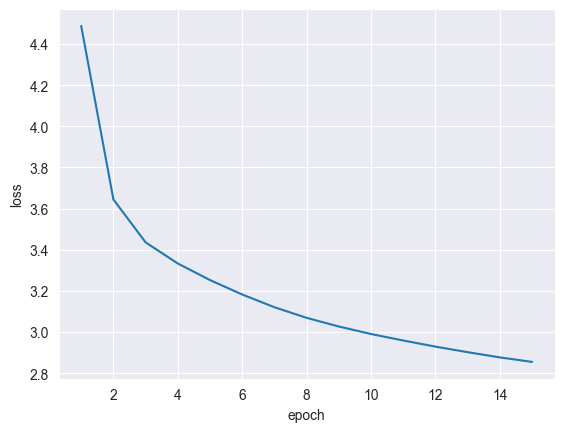

In [194]:
losses = []
num_epochs = 15

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        loss = training_step(model, batch, tokenizer.vocab_size, criterion, optimizer, device)
        epoch_loss += loss
        
        if i % 100 == 0:
            print(f'Done {i/len(dataloader) * 100:.2f}%, Loss: {loss:.4f}')
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    plot_losses(losses)
    torch.save(model.state_dict(), "mylstm.pt")

In [206]:
optimizer.param_groups[0]['lr'] = 1e-4

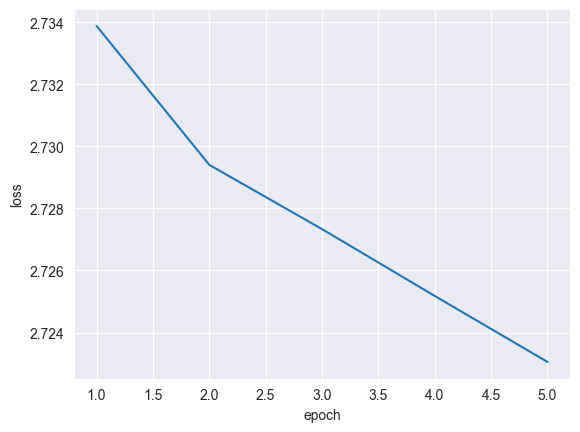

In [207]:
losses = []
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        loss = training_step(model, batch, tokenizer.vocab_size, criterion, optimizer, device)
        epoch_loss += loss
        
        if i % 100 == 0:
            print(f'Done {i/len(dataloader) * 100:.2f}%, Loss: {loss:.4f}')
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    plot_losses(losses)
    torch.save(model.state_dict(), "mylstm.pt")

In [213]:
text[0]

'Только заметил, что слово "п@рно" набирается самими центральными клавишами. Как все продумано, блин!'

In [219]:
[model.inference('только заметил, что слово', device=device) for _ in range(10)]

['только заметил, что слово все нельзя для тыной я деньчных?- олмовте таку выбилу".',
 'только заметил, что слово любь.- ожешь быть в кроме?- ака.-  ты.- о не нлатера.',
 'только заметил, что слово по одинсис два, когда я должен выдухоту и жестрясь!',
 'только заметил, что слово выносили с ригры, лив вабезь и тронькый - на небо удуни я они как, чернить в сразу и встечась...',
 'только заметил, что слово сотове перездутелю чаего: к этоц вам исзрет!  все озлеся - поймал прикидем , коньное страмали людей".',
 'только заметил, что слово, по смупемых ялациик обхружи и 5300 мина ему только она на плелствий.  мужчин, как у меня хей на мелос.',
 'только заметил, что слово призды чувстунит в легные матеролах.  не вся.',
 'только заметил, что слово задумался дав, а раз все подвела коб в разной. о мальная вечером но сврехока.',
 'только заметил, что слово обятался. н к луску оперокся и почезмой.',
 'только заметил, что слово насям нетая в эту орчиби нок и стусдонный два так песу в певею!  угьма -

В принципе не могу сказать что это сильно лучше или хуже, чем символьная модель. Лосс номинально намного больше, но это скорее потому что теперь тут 500 реальных токенов, а не 217, половина из которых почти не встречается. Примечательно что во всех случаях модель поняла что после "слово" надо поставить пробел. Но в целом как был бред, так и остался.

### Задание 2

In [3]:
import my_nn

class CellRNN(my_nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.rnn = my_nn.Linear(2 * hidden_size, hidden_size, gain=5/3)
        self.tanh = my_nn.Tanh()
        
        self.out = my_nn.Linear(hidden_size, hidden_size, gain=1)
        
    def forward(self, x, h):
        new_x = np.zeros_like(x, dtype=my_nn.Element)
        if len(x.shape) < 2:
            raise ValueError(f'Expected 2D input (BxH), but found {x.shape}')
        for batch_num in range(x.shape[0]):
            for element_num in range(len(x[batch_num])):
                h[batch_num] = self.tanh(self.rnn(np.hstack((x[batch_num][element_num], h[batch_num]))))
                new_x[batch_num][element_num] = self.out(h[batch_num])
        
        return new_x, h

### В качестве простого тестового задания наша нейронка будет учится предсказывать значение функции ln(cos(x))

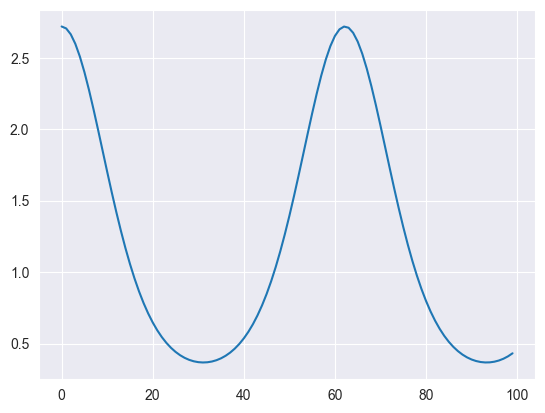

In [103]:
x = np.linspace(0, 10, 100).reshape(1, -1)
x = np.exp(np.cos(x))
plt.plot(x[0, :])
plt.show()

### Используем наш ранее написанный оптимизатор

In [4]:
class Adam:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.params = list(params)
        self.m = {}
        self.s = {}

    # теперь не принимает на вход параметры и градиенты
    def step(self):
        if not self.m:
            self.m = [np.zeros_like(p) for p in self.params]
            self.s = [np.zeros_like(p) for p in self.params]
        for i, param in enumerate(self.params):
            g = param.grad
            m = self.m[i]
            s = self.s[i]

            m = self.beta1 * m + (1 - self.beta1) * g
            s = self.beta2 * s + (1 - self.beta2) * (g ** 2)

            param.data -= self.lr * m / (np.sqrt(s) + self.eps)

            self.m[i] = m
            self.s[i] = s

    # написали свой zero_grad
    def zero_grad(self):
        for param in self.params:
            param.grad = 0

In [135]:
rnn = CellRNN(hidden_size=1)
optimizer = Adam(rnn.parameters(), lr=0.01)
criterion = lambda a, b : np.sum((a - b) ** 2)

In [136]:
num_epochs = 200
for epoch in range(num_epochs):
    h = np.zeros((1, 1), dtype=my_nn.Element)
    inputs = x[:, :-1]
    targets = x[:, 1:]
    
    preds, h = rnn(inputs, h)
    loss = criterion(preds, targets)
    optimizer.zero_grad()
    loss[0].backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss[0].data:.4f}')

Epoch 1/200, Loss: 56.2528
Epoch 2/200, Loss: 53.4151
Epoch 3/200, Loss: 49.4269
Epoch 4/200, Loss: 43.8626
Epoch 5/200, Loss: 36.0918
Epoch 6/200, Loss: 27.3180
Epoch 7/200, Loss: 21.4171
Epoch 8/200, Loss: 20.0011
Epoch 9/200, Loss: 18.2408
Epoch 10/200, Loss: 14.3279
Epoch 11/200, Loss: 10.4147
Epoch 12/200, Loss: 8.2908
Epoch 13/200, Loss: 7.8375
Epoch 14/200, Loss: 7.5530
Epoch 15/200, Loss: 6.3887
Epoch 16/200, Loss: 4.5844
Epoch 17/200, Loss: 3.1061
Epoch 18/200, Loss: 2.7154
Epoch 19/200, Loss: 3.1828
Epoch 20/200, Loss: 3.4036
Epoch 21/200, Loss: 2.8258
Epoch 22/200, Loss: 1.9991
Epoch 23/200, Loss: 1.6544
Epoch 24/200, Loss: 1.9009
Epoch 25/200, Loss: 2.2401
Epoch 26/200, Loss: 2.1923
Epoch 27/200, Loss: 1.7656
Epoch 28/200, Loss: 1.3394
Epoch 29/200, Loss: 1.2295
Epoch 30/200, Loss: 1.3753
Epoch 31/200, Loss: 1.4511
Epoch 32/200, Loss: 1.2744
Epoch 33/200, Loss: 0.9838
Epoch 34/200, Loss: 0.8249
Epoch 35/200, Loss: 0.8733
Epoch 36/200, Loss: 0.9898
Epoch 37/200, Loss: 1.0061

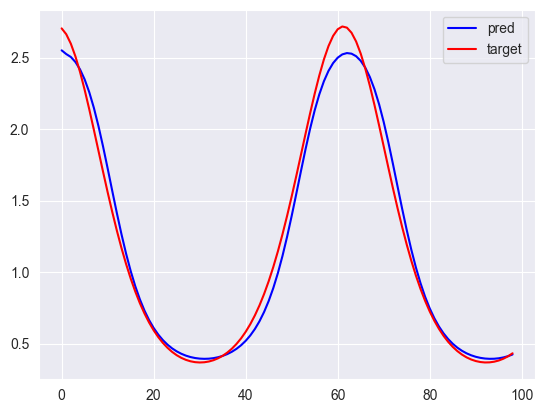

In [22]:
plt.plot([pred[0].data for pred in preds[0, :]], color='blue', label='pred')
plt.plot(targets[0, :], color='red', label='target')
plt.legend()
plt.show()

### Мы видим что лосс уменьшается и модель научилась предсказывать целевую функцию 

### Теперь сделаем многослойную RNN на основе однослойной

In [5]:
class RNN(my_nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnns = [CellRNN(hidden_size=self.hidden_size) for _ in range(num_layers)]
    def forward(self, x, h):
        new_x, h[:,0, :] = self.rnns[0].forward(x, h[:,0,:])
        for i in range(1, len(self.rnns)):
            new_x, h[:,i, :] = self.rnns[i].forward(new_x, h[:,i, :])
        return new_x, h

In [27]:
rnn = RNN(hidden_size=1, num_layers=2)
optimizer = Adam(rnn.parameters(), lr=0.01)
criterion = lambda a, b : np.sum((a - b) ** 2)

In [28]:
num_epochs = 200
for epoch in range(num_epochs):
    h = np.zeros((1, 2, 1), dtype=my_nn.Element)
    inputs = x[:, :-1]
    targets = x[:, 1:]
    
    preds, h = rnn(inputs, h)
    loss = criterion(preds, targets)
    optimizer.zero_grad()
    loss[0].backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss[0].data:.4f}')

Epoch 1/200, Loss: 85.3954
Epoch 2/200, Loss: 79.8406
Epoch 3/200, Loss: 72.9845
Epoch 4/200, Loss: 65.1702
Epoch 5/200, Loss: 55.6393
Epoch 6/200, Loss: 44.6631
Epoch 7/200, Loss: 37.1578
Epoch 8/200, Loss: 33.2300
Epoch 9/200, Loss: 27.1124
Epoch 10/200, Loss: 21.2282
Epoch 11/200, Loss: 17.8749
Epoch 12/200, Loss: 15.9573
Epoch 13/200, Loss: 13.3863
Epoch 14/200, Loss: 10.2195
Epoch 15/200, Loss: 7.8102
Epoch 16/200, Loss: 6.8767
Epoch 17/200, Loss: 6.3507
Epoch 18/200, Loss: 5.1211
Epoch 19/200, Loss: 3.6264
Epoch 20/200, Loss: 2.7789
Epoch 21/200, Loss: 2.6202
Epoch 22/200, Loss: 2.3945
Epoch 23/200, Loss: 1.7930
Epoch 24/200, Loss: 4.7181
Epoch 25/200, Loss: 1.6498
Epoch 26/200, Loss: 2.0162
Epoch 27/200, Loss: 2.0006
Epoch 28/200, Loss: 1.6396
Epoch 29/200, Loss: 1.3957
Epoch 30/200, Loss: 1.5055
Epoch 31/200, Loss: 1.7445
Epoch 32/200, Loss: 1.7826
Epoch 33/200, Loss: 1.6021
Epoch 34/200, Loss: 1.4469
Epoch 35/200, Loss: 1.4885
Epoch 36/200, Loss: 1.6400
Epoch 37/200, Loss: 1.6

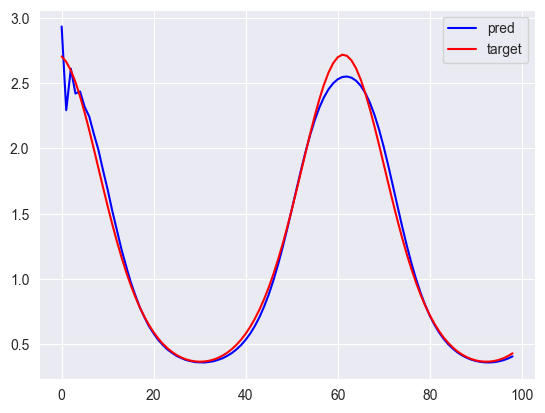

In [29]:
plt.plot([pred[0].data for pred in preds[0, :]], color='blue', label='pred')
plt.plot(targets[0, :], color='red', label='target')
plt.legend()
plt.show()

### Все снова работает

### Теперь перепишем все составные части классной работы чтобы сделать ее на своей нейронке

In [12]:
class MyJokesDataset():
    def __init__(self, tokenizer, cut_text, max_len: int = 256):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
            
    def __len__(self):
        return len(self.cut_text)
    
    def __getitem__(self, item):
        encoded = self.tokenizer.encode(self.cut_text[item].lower()).numpy()
        return encoded

### Напишем слой эмбеддинг который будет выступать в роли энкодера

In [13]:
class Embedding(my_nn.HasParameters):
    def __init__(self, in_features, out_features):
        super().__init__()
        std = np.sqrt(2 / (in_features + out_features))
        self.W = my_nn.elementize(np.random.normal(loc=0, scale=std, size=(in_features, out_features)))
        self.b = my_nn.elementize(np.zeros(out_features) + 0.01)

        self.params = [*self.W.flatten().tolist(), *self.b.tolist()]
        
        self.out_features = out_features

    def __call__(self, x):
        # x: BxL
        res = np.zeros((x.shape[0], x.shape[1], self.out_features), dtype=my_nn.Element)
        # return self.W[x] + self.b
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                res[i][j] = self.W[x[i][j]] + self.b
        return res

### Делаем модель на основе классной работы с небольшими изменениями

In [14]:
class MyStackedRNN(my_nn.Module):
    def __init__(self, tokenizer, hidden_dim: int = 256, num_layers: int = 2, drop_prob: float = 0.5, max_len: int = 512) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        self.tokenizer = tokenizer

        self.encoder = Embedding(self.tokenizer.vocab_size, self.hidden_dim)
        self.rnn = RNN(hidden_size=self.hidden_dim, num_layers=self.num_layers)
        self.decoder = my_nn.Linear(in_features=self.hidden_dim, out_features=self.tokenizer.vocab_size, gain=1)

    def forward(self, x, h):
        x = self.encoder(x)
        outputs, hidden = self.rnn(x, h)
        outputs = self.decoder(outputs)
        
        return outputs, hidden
    
    def init_hidden(self, batch_size=1):
        return np.zeros((batch_size, self.num_layers, self.hidden_dim), dtype=my_nn.Element)
    
    def inference(self, prefix=""):
        tokens = self.tokenizer.encode(prefix, eos=False, padding=False).numpy().reshape(1, -1)
        hidden = self.init_hidden()
        for _ in range(self.max_len - len(tokens)):
            logits, hidden = self.forward(tokens, hidden)
            
            next_token_logits = logits[:, -1, :]
            new_token = torch.multinomial(torch.tensor(my_nn.numerize(my_nn.softmax(next_token_logits)).astype(float)), 1).numpy()

            tokens = np.hstack((tokens, new_token))

            if new_token == self.tokenizer.vocab['[EOS]']:
                break

        return self.tokenizer.decode(torch.tensor(tokens).squeeze())

### Максимально упростим все составные части, потому что работает все это дело чудовищно медленно

In [15]:
tokenizer = Tokenizer(vocab_size=256, max_len=32)

In [16]:
tokenizer.train(all_texts, new_dict)

Added "по", new dict size: 52
Added "на", new dict size: 53
Added "не", new dict size: 54
Added "ко", new dict size: 55
Added "пр", new dict size: 56
Added "ра", new dict size: 57
Added "ст", new dict size: 58
Added "то", new dict size: 59
Added "ка", new dict size: 60
Added "но", new dict size: 61
Added "те", new dict size: 62
Added "да", new dict size: 63
Added "де", new dict size: 64
Added "во", new dict size: 65
Added "ть", new dict size: 66
Added "та", new dict size: 67
Added "за", new dict size: 68
Added "чт", new dict size: 69
Added "ни", new dict size: 70
Added "ли", new dict size: 71
Added "что", new dict size: 72
Added "ит", new dict size: 73
Added "мо", new dict size: 74
Added "от", new dict size: 75
Added "ро", new dict size: 76
Added "го", new dict size: 77
Added "ал", new dict size: 78
Added "до", new dict size: 79
Added "ен", new dict size: 80
Added "ре", new dict size: 81
Added "ет", new dict size: 82
Added "ат", new dict size: 83
Added "ов", new dict size: 84
Added "он

In [17]:
my_dataset = MyJokesDataset(tokenizer, text, 32)

In [18]:
tokenizer.decode(torch.tensor(my_dataset[0]))

'только заметил, что слово "п@рно" набирается сами'

### Попутно написали класс даталоадера

In [19]:
my_dataloader = my_nn.Dataloader(my_dataset, batch_size=16)

In [20]:
next(iter(my_dataloader))

array([[  2, 246,  77, 110,   8,  10,   8, 184,  22,  60,  39,   8,  57,
         99, 111,  21,  24,   8,  18,  22,  28,  45,  45,  45,   8,   6,
         28,  45,  45,  45,   8,   3],
       [  2,  43,   8, 120,  14,   8,  54,  53,  50,  60,  14,   8,  10,
        130,   5,   8, 120,   8,  10,   8, 233, 228, 227,   8, 134,  10,
         14,   8,  60,   8,  61,   3],
       [  2,  43,   8, 116,  50,  10,  14,   8,  71, 120,   8,  30,  58,
         24,  69, 226,   7,   8,  51, 245, 104,   8, 103,   8, 167,  99,
         45,   8,  60,   8,  98,   3],
       [  2,  18, 175,  23, 246,  23,  59,   8, 163, 222, 185, 200,  81,
          8,  29,   8,  18, 175,  23, 246,  23,  54,  39,  21,  24,   8,
        207,   9, 190,  15,   5,   3],
       [  2,   9, 139, 121,  49,  39,   8,  93, 194, 152, 225,   8,  51,
        119,  20,  44,  77,   8, 253,  37,   4,  62,  52,  28,   8,  22,
         13,   8, 199, 161, 211,   3],
       [  2,  67, 116,   9,  43,   8,  15,   8, 142, 246,  30,  14,   8,
  

In [21]:
seq_length = 32
n_hidden = 16
n_layers = 2
drop_prob = 0.1
lr = 0.001

### Допишем нашему элементу логарифм

In [6]:
def log(self):
    res = my_nn.Element(np.log(self.data), tuple([self]), 'log')
    
    def _backward():
        self.grad += 1 / self.data * res.grad
        
    res._backward = _backward
    return res

my_nn.Element.log = lambda self: log(self)

### И создадим лосс

In [7]:
class CrossEntropyLoss:
    def __init__(self, ignore_index=None):
        self.ignore_index = ignore_index
    def __call__(self, y_pred, y_true):
        loss = my_nn.Element(0)
        probs = my_nn.softmax(y_pred)
        for i in range(len(y_true)):
            # Игнорируем паддинг
            if y_true[i] == self.ignore_index:
                continue
            loss -= probs[i][y_true[i]].log()
        return loss

In [138]:
model = MyStackedRNN(tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob, max_len=seq_length)
criterion = CrossEntropyLoss(ignore_index=0)
optimizer = Adam(model.parameters(), lr=1e-3)

### Вроде работает

In [23]:
batch = next(iter(my_dataloader))
sample_res = model(batch, model.init_hidden(16))
sample_res

(array([[[Element(data=0.045455752345292234, grad=0),
          Element(data=0.04200464165813208, grad=0),
          Element(data=-0.03781437415645339, grad=0), ...,
          Element(data=0.06628324741289846, grad=0),
          Element(data=0.10266037347104139, grad=0),
          Element(data=-0.005387571970403111, grad=0)],
         [Element(data=0.1568412366255506, grad=0),
          Element(data=-0.12422578190009319, grad=0),
          Element(data=0.052909054256021756, grad=0), ...,
          Element(data=0.04208719639537706, grad=0),
          Element(data=0.005034479311586246, grad=0),
          Element(data=-0.01542795623570657, grad=0)],
         [Element(data=0.07287712862303308, grad=0),
          Element(data=0.17089719995597444, grad=0),
          Element(data=0.06441133647577131, grad=0), ...,
          Element(data=-0.11209367134158406, grad=0),
          Element(data=0.1582443078892601, grad=0),
          Element(data=0.10038491959159224, grad=0)],
         ...,
       

In [26]:
model.inference('привет')

'приветгодвбылжислинаавдводнтаксаеслимуувсекааекоогоусюкогитьил@лженаяокойоди'

In [90]:
def training_step(model, train_batch, vocab_size, criterion, optimizer):
    inputs = train_batch

    hidden = model.init_hidden(len(train_batch))
    outputs, _ = model(inputs[:, :-1], hidden)

    outputs = outputs.reshape(-1, vocab_size)
    targets = inputs[:, 1:].reshape(-1)

    loss = criterion(outputs, targets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.data

### Перепишем backward без рекурсии потому что питон ругается

In [8]:
def backward(self):       
    topo = []
    dfs = [self]
    visited = set()
    
    def build_topo():
        while len(dfs) != 0:
            v = dfs[-1]
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    if child not in visited:
                        dfs.append(child)
            else:
                topo.append(dfs.pop())
                                 

    build_topo()
    self.grad = 1
    for v in reversed(topo):
        v._backward()
        
my_nn.Element.backward = lambda self: backward(self)

### Запускаем обучение

In [139]:
losses = []
num_epochs = 1

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    for i, batch in enumerate(my_dataloader):
        loss = training_step(model, batch, 256, criterion, optimizer)
        epoch_loss += loss
        
        print(f'Done {i/len(my_dataloader) * 100:.2f}%, Loss: {loss:.4f}')
        
        if i == 3:
            break
    epoch_loss /= len(my_dataloader)
    losses.append(epoch_loss)

Done 0.00%, Loss: 5651.0570
Done 0.01%, Loss: 5587.9236
Done 0.03%, Loss: 5750.5622
Done 0.04%, Loss: 5744.7319


### Запустим еще раз на тех же батчах

In [140]:
losses = []
num_epochs = 1

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    for i, batch in enumerate(my_dataloader):
        loss = training_step(model, batch, 256, criterion, optimizer)
        epoch_loss += loss
        
        print(f'Done {i/len(my_dataloader) * 100:.2f}%, Loss: {loss:.4f}')
        
        if i == 3:
            break
    epoch_loss /= len(my_dataloader)
    losses.append(epoch_loss)

Done 0.00%, Loss: 5532.6489
Done 0.01%, Loss: 5446.3920
Done 0.03%, Loss: 5580.8324
Done 0.04%, Loss: 5565.9999


### Лосс уменьшается, значит все работает корректно. Обучить до какого-то продвинутого состояния возможности нет, т.к. один батч обрабатывается 1.5 минуты. (то есть эпоха обработается за 8 дней)))))

### Перейдем к LSTM/GRU/Bidirectional

### В целом ничего нового, можно снова сделать все на наших линейных слоях и операций с их выводами 

### Однослойная LSTM

In [9]:
class CellLSTM(my_nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.forget = my_nn.Linear(2 * hidden_size, hidden_size)
        self.input = my_nn.Linear(2 * hidden_size, hidden_size)
        self.output = my_nn.Linear(2 * hidden_size, hidden_size)
        
        self.sigmoid = my_nn.Sigmoid()
        self.tanh = my_nn.Tanh()
        
        self.c = my_nn.Linear(2 * hidden_size, hidden_size, gain=5/3)
        
    def forward(self, x, h):
        new_x = np.zeros_like(x, dtype=my_nn.Element)
        for batch_num in range(x.shape[0]):
            c = np.zeros(self.hidden_size)
            for element_num in range(len(x[batch_num])):
                f = self.sigmoid(self.forget(np.hstack((x[batch_num][element_num], h[batch_num]))))
                i = self.sigmoid(self.forget(np.hstack((x[batch_num][element_num], h[batch_num]))))
                o = self.sigmoid(self.forget(np.hstack((x[batch_num][element_num], h[batch_num]))))
                c_hat = self.tanh(self.forget(np.hstack((x[batch_num][element_num], h[batch_num]))))
                
                c = f * c + i * c_hat
                h[batch_num] = o * self.tanh(c)
                new_x[batch_num][element_num] = h[batch_num]
        return new_x

### Многослойная LSTM

In [10]:
class LSTM(my_nn.Module):
    def __init__(self, hidden_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.layers = [CellLSTM(hidden_size) for _ in range(num_layers)]    
        
    def forward(self, x):
        batch_size = x.shape[0]
        for layer in self.layers:
            h = np.zeros((batch_size, self.hidden_size), dtype=my_nn.Element)
            x = layer(x, h)
        return x


### Аналогично для GRU

In [149]:
class CellGRU(my_nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.r = my_nn.Linear(2 * hidden_size, hidden_size)
        self.z = my_nn.Linear(2 * hidden_size, hidden_size)
        self.h_hat = my_nn.Linear(2 * hidden_size, hidden_size, gain=5/3)
        
        self.sigmoid = my_nn.Sigmoid()
        self.tanh = my_nn.Tanh()
        
    def forward(self, x, h):
        new_x = np.zeros_like(x, dtype=my_nn.Element)
        for batch_num in range(x.shape[0]):
            for element_num in range(len(x[batch_num])):
                r = self.sigmoid(self.r(np.hstack((x[batch_num][element_num], h[batch_num]))))
                z = self.sigmoid(self.z(np.hstack((x[batch_num][element_num], h[batch_num]))))
                
                h_hat = self.tanh(self.h_hat(np.hstack((x[batch_num][element_num], r * h[batch_num]))))
                
                h[batch_num] = h[batch_num] * (1 - z) + h_hat * z
                new_x[batch_num][element_num] = h[batch_num]
        return new_x

### Многослойный GRU

In [150]:
class GRU(my_nn.Module):
    def __init__(self, hidden_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.layers = [CellGRU(hidden_size) for _ in range(num_layers)]    
        
    def forward(self, x):
        batch_size = x.shape[0]
        for layer in self.layers:
            h = np.zeros((batch_size, self.hidden_size), dtype=my_nn.Element)
            x = layer(x, h)
        return x

In [167]:
x = np.linspace(0, 10, 100).reshape(1, -1)
x = np.exp(np.cos(x))

rnn = GRU(hidden_size=1, num_layers=2)
optimizer = Adam(rnn.parameters(), lr=0.001)
criterion = lambda a, b : np.sum((a - b) ** 2)

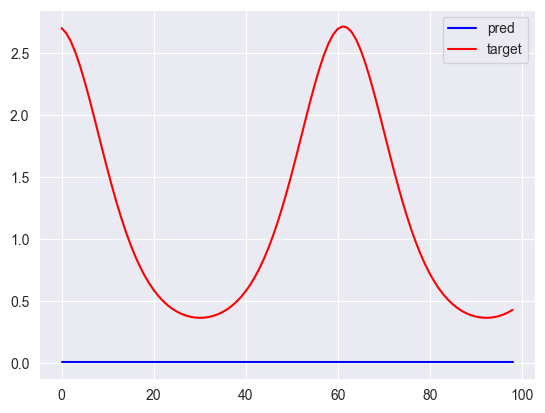

In [168]:
preds = rnn(x[:, :-1])
plt.plot([pred[0].data for pred in preds[0, :]], color='blue', label='pred')
plt.plot(x[:, 1:][0, :], color='red', label='target')
plt.legend()
plt.show()

In [169]:
num_epochs = 500
for epoch in range(num_epochs):
    inputs = x[:, :-1]
    targets = x[:, 1:]
    
    preds = rnn(inputs)
    loss = criterion(preds, targets)
    optimizer.zero_grad()
    loss[0].backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss[0].data:.4f}')

Epoch 1/500, Loss: 208.1465
Epoch 2/500, Loss: 207.2371
Epoch 3/500, Loss: 206.0288
Epoch 4/500, Loss: 204.6592
Epoch 5/500, Loss: 203.1859
Epoch 6/500, Loss: 201.5921
Epoch 7/500, Loss: 199.9046
Epoch 8/500, Loss: 198.1357
Epoch 9/500, Loss: 196.3615
Epoch 10/500, Loss: 194.5787
Epoch 11/500, Loss: 192.7741
Epoch 12/500, Loss: 190.9351
Epoch 13/500, Loss: 189.0305
Epoch 14/500, Loss: 187.1507
Epoch 15/500, Loss: 185.2089
Epoch 16/500, Loss: 183.3030
Epoch 17/500, Loss: 181.3427
Epoch 18/500, Loss: 179.4249
Epoch 19/500, Loss: 177.4994
Epoch 20/500, Loss: 175.5774
Epoch 21/500, Loss: 173.6963
Epoch 22/500, Loss: 171.8261
Epoch 23/500, Loss: 169.9860
Epoch 24/500, Loss: 168.0652
Epoch 25/500, Loss: 166.1678
Epoch 26/500, Loss: 164.2759
Epoch 27/500, Loss: 162.3890
Epoch 28/500, Loss: 160.4686
Epoch 29/500, Loss: 158.5763
Epoch 30/500, Loss: 156.7078
Epoch 31/500, Loss: 154.8043
Epoch 32/500, Loss: 152.9129
Epoch 33/500, Loss: 151.0590
Epoch 34/500, Loss: 149.1612
Epoch 35/500, Loss: 147

In [170]:
rnn.parameters()

[Element(data=0.2838778336215118, grad=0.11785923780298513),
 Element(data=-0.43421781180347807, grad=0.231491789047784),
 Element(data=-0.6891685108848056, grad=0.29330362473743243),
 Element(data=0.39699179278781144, grad=-0.009202797385517478),
 Element(data=-0.42937207889835743, grad=-0.017895471638187815),
 Element(data=0.6731699625759469, grad=-0.022644357434448953),
 Element(data=1.565168060150324, grad=-0.8580535599362933),
 Element(data=-0.8527386914429494, grad=-0.4812801361903835),
 Element(data=0.6604839878994453, grad=-2.1357194263382255),
 Element(data=0.7064216514063649, grad=-0.11972104541784356),
 Element(data=2.734863341453452, grad=-0.14123233504050664),
 Element(data=0.6366061494477555, grad=-0.14975222471388075),
 Element(data=1.7919024753640425, grad=-4.229718496346894e-15),
 Element(data=-1.5078593181213114, grad=-4.941421530345512e-15),
 Element(data=0.10301223480879905, grad=-5.290713529360754e-15),
 Element(data=0.6535636800840594, grad=-7.285527795388859),
 E

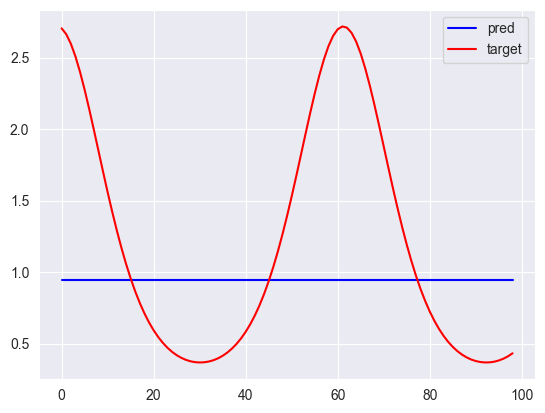

In [171]:
plt.plot([pred[0].data for pred in preds[0, :]], color='blue', label='pred')
plt.plot(targets[0, :], color='red', label='target')
plt.legend()
plt.show()

### GRU и LSTM как-то не очень решают эту задачу. Лосс уменьшается но очень медленно, видимо задача не для них

### Bidirectional

### Снова сделаем все на линейный слоях. Все также как в обычной RNN, но у нас два h, один "едет" слева направо, другой наоборот

In [122]:
class CellBRNN(my_nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.rnn_left = my_nn.Linear(2 * hidden_size, hidden_size, gain=5/3)
        self.rnn_right = my_nn.Linear(2 * hidden_size, hidden_size, gain=5/3)
        self.tanh = my_nn.Tanh()
        
        self.out = my_nn.Linear(2 * hidden_size, hidden_size, gain=1)
        
    def forward(self, x):
        new_x = np.zeros_like(x, dtype=my_nn.Element)
        h_shape = list(x.shape)
        h_shape[-1] += 1
        h_shape = tuple(h_shape)
        h_left = np.zeros(h_shape, dtype=my_nn.Element)
        h_right = np.zeros(h_shape, dtype=my_nn.Element)
        
        x_len = x.shape[1]
        for batch_num in range(x.shape[0]):
            for element_num in range(x_len):
                h_left[batch_num][element_num + 1] = self.tanh(self.rnn_left(
                    np.hstack((x[batch_num][element_num], h_left[batch_num][element_num]))))
                h_right[batch_num][x_len - element_num - 2] = self.tanh(self.rnn_left(
                    np.hstack((x[batch_num][x_len - element_num - 1], h_right[batch_num][x_len - element_num]))))
            for element_num in range(x_len):    
                new_x[batch_num][element_num] = self.out(np.hstack((h_left[batch_num][element_num + 1], h_right[batch_num][element_num])))
        return new_x

### Многослойная BRNN

In [128]:
class BRNN(my_nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnns = [CellBRNN(hidden_size=self.hidden_size) for _ in range(num_layers)]
    def forward(self, x):
        for layer in self.rnns:
            x = layer(x)
        return x

In [129]:
x = np.linspace(0, 10, 100).reshape(1, -1)
x = np.exp(np.cos(x))

rnn = BRNN(hidden_size=1, num_layers=2)
optimizer = Adam(rnn.parameters(), lr=0.001)
criterion = lambda a, b : np.sum((a - b) ** 2)

In [146]:
num_epochs = 100
for epoch in range(num_epochs):
    inputs = x[:, :-1]
    targets = x[:, 1:]
    
    preds = rnn(inputs)
    loss = criterion(preds, targets)
    optimizer.zero_grad()
    loss[0].backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss[0].data:.4f}')

Epoch 1/100, Loss: 2.7804
Epoch 2/100, Loss: 2.7754
Epoch 3/100, Loss: 2.7704
Epoch 4/100, Loss: 2.7655
Epoch 5/100, Loss: 2.7605
Epoch 6/100, Loss: 2.7556
Epoch 7/100, Loss: 2.7507
Epoch 8/100, Loss: 2.7457
Epoch 9/100, Loss: 2.7409
Epoch 10/100, Loss: 2.7360
Epoch 11/100, Loss: 2.7311
Epoch 12/100, Loss: 2.7263
Epoch 13/100, Loss: 2.7215
Epoch 14/100, Loss: 2.7167
Epoch 15/100, Loss: 2.7119
Epoch 16/100, Loss: 2.7071
Epoch 17/100, Loss: 2.7024
Epoch 18/100, Loss: 2.6976
Epoch 19/100, Loss: 2.6929
Epoch 20/100, Loss: 2.6882
Epoch 21/100, Loss: 2.6835
Epoch 22/100, Loss: 2.6789
Epoch 23/100, Loss: 2.6742
Epoch 24/100, Loss: 2.6696
Epoch 25/100, Loss: 2.6649
Epoch 26/100, Loss: 2.6603
Epoch 27/100, Loss: 2.6557
Epoch 28/100, Loss: 2.6512
Epoch 29/100, Loss: 2.6466
Epoch 30/100, Loss: 2.6421
Epoch 31/100, Loss: 2.6375
Epoch 32/100, Loss: 2.6330
Epoch 33/100, Loss: 2.6285
Epoch 34/100, Loss: 2.6240
Epoch 35/100, Loss: 2.6196
Epoch 36/100, Loss: 2.6151
Epoch 37/100, Loss: 2.6107
Epoch 38/1

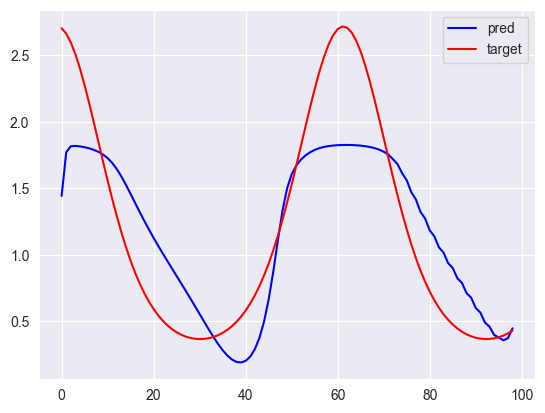

In [137]:
plt.plot([pred[0].data for pred in preds[0, :]], color='blue', label='pred')
plt.plot(targets[0, :], color='red', label='target')
plt.legend()
plt.show()

### Этой сети явно лучше подходит данная задача. Сверху виден промежуточный результат, как она приближается к цели. Снизу более обученная модель. Видны косяки на концах, когда еще мало информации

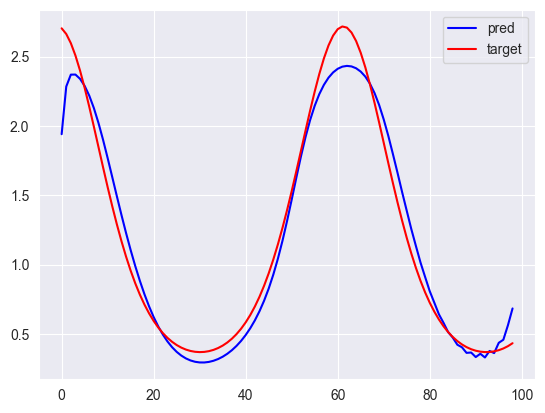

In [147]:
plt.plot([pred[0].data for pred in preds[0, :]], color='blue', label='pred')
plt.plot(targets[0, :], color='red', label='target')
plt.legend()
plt.show()